<a href="https://colab.research.google.com/github/AdirGelkop/Deep_Learning_Course_Project/blob/main/DL_25_1_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project Notebook
This notebook documents the complete workflow for our deep learning project, starting with data preparation. Each section corresponds to a step in the project, and the notebook will be updated incrementally as we progress.

## **Introduction**
This project focuses on building a custom deep learning model for analyzing and predicting global economic indicators. The dataset used contains various economic metrics from 2010 to 2023. This notebook will cover all stages:
1. Data Preparation
2. Exploratory Data Analysis
3. Model Design and Training
4. Evaluation
5. Conclusions

## **1. Data Preparation**

In [1]:
#!pip install --upgrade pandas-datareader
#!pip install fredapi


### **1.1 Import Libraries**

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
import torch
import torch.optim as optim
#import pandas_datareader as pdr
from fredapi import Fred

import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings

#------------------------------------------------------------------------------

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
import kagglehub

# Set visualization styles
sns.set(style="whitegrid")

### **1.2 Download and Inspect the Dataset**

In [3]:
# Check if the dataset file exists and load it
#path = kagglehub.dataset_download("prasad22/global-economy-indicators")
path = kagglehub.dataset_download("heidarmirhajisadati/global-economic-indicators-dataset-2010-2023")
file_path = os.path.join(path, os.listdir(path)[0])  # Get the first file

if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist. Check the dataset download.")

# Load the dataset
print("Loading dataset...")
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("\nDataset Info:")
data.info()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())
print("\nNo NaN treatment is required !")

# Only USA-related data
usa_data = data[data['Country'] == 'USA']

# Display the first 5 rows of the dataset
print("\nFirst 5 rows:\n")
usa_data.head()


Loading dataset...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   500 non-null    object 
 1   Country                500 non-null    object 
 2   Inflation Rate (%)     500 non-null    float64
 3   GDP Growth Rate (%)    500 non-null    float64
 4   Unemployment Rate (%)  500 non-null    float64
 5   Interest Rate (%)      500 non-null    float64
 6   Stock Index Value      500 non-null    float64
dtypes: float64(5), object(2)
memory usage: 27.5+ KB

Missing Values:
Date                     0
Country                  0
Inflation Rate (%)       0
GDP Growth Rate (%)      0
Unemployment Rate (%)    0
Interest Rate (%)        0
Stock Index Value        0
dtype: int64

No NaN treatment is required !

First 5 rows:



,Date,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
2,2010-01-31,USA,7.46,4.84,2.64,6.39,13129.10
7,2010-02-28,USA,3.13,4.82,9.32,-0.66,10638.13
9,2010-03-31,USA,7.20,-1.48,4.10,8.22,6067.71
17,2010-06-30,USA,5.56,0.87,4.54,3.34,2104.14
35,2011-01-31,USA,0.09,-1.82,11.92,-0.06,31674.37


### **1.3 Data Cleansing**

In [4]:
# Ensure Date column is in datetime format and set it as the index
usa_data['Date'] = pd.to_datetime(usa_data['Date'])
#usa_data = data.loc[data['Country'] == 'USA'].copy()
usa_data = usa_data.set_index('Date')

# Drop duplicate dates, keeping the first occurrence
usa_data = usa_data[~usa_data.index.duplicated(keep='first')]

# Resample to include all months (last day of each month)
usa_data = usa_data.resample('M').asfreq()

# Fill missing numeric columns with linear interpolation
usa_data = usa_data.interpolate(method='linear')
# Forward fill remaining "country" missing values
usa_data = usa_data.fillna(method='ffill')
usa_data = usa_data.fillna(method='bfill')

# Verify the final dataset
print("\nData after handling missing dates and values:\n")
usa_data.head()



Data after handling missing dates and values:



<ipython-input-4-a793a9f338f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['Date'] = pd.to_datetime(usa_data['Date'])


,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Stock Index Value
Date,,,,,,
2010-01-31,USA,7.460000,4.840000,2.640000,6.390000,13129.10
2010-02-28,USA,3.130000,4.820000,9.320000,-0.660000,10638.13
2010-03-31,USA,7.200000,-1.480000,4.100000,8.220000,6067.71
2010-04-30,USA,6.653333,-0.696667,4.246667,6.593333,4746.52
2010-05-31,USA,6.106667,0.086667,4.393333,4.966667,3425.33


### **1.4 Feature Engineering**

In [5]:
# Adding the feature 'Inflation-Adjusted Interest Rate'
# as it reflects the true cost of borrowing after accounting for inflation and is a strong economic indicator
usa_data['Inflation-Adjusted Interest Rate'] = usa_data['Interest Rate (%)'] - usa_data['Inflation Rate (%)']

# Adding the feature 'Stock Market Volatility'
# as it reflects the rate of change in the stock index value to capture market dynamics
usa_data['Stock Market Volatility'] = usa_data['Stock Index Value'].pct_change() * 100

# Adding the feature 'Economic Stress Index'
# as it reflects the combined pressure on an economy from inflation, unemployment, and the cost of borrowing (adjusted for inflation)
usa_data['Economic Stress Index'] = (usa_data['Inflation Rate (%)'] + usa_data['Unemployment Rate (%)'] - usa_data['Inflation-Adjusted Interest Rate'])

# Handle NaN values in new features
usa_data['Inflation-Adjusted Interest Rate'] = usa_data['Inflation-Adjusted Interest Rate'].fillna(method='ffill')
usa_data['Inflation-Adjusted Interest Rate'] = usa_data['Inflation-Adjusted Interest Rate'].fillna(method='bfill')
usa_data['Stock Market Volatility'] = usa_data['Stock Market Volatility'].fillna(method='ffill')
usa_data['Stock Market Volatility'] = usa_data['Stock Market Volatility'].fillna(method='bfill')
usa_data['Economic Stress Index'] = usa_data['Economic Stress Index'].fillna(method='ffill')
usa_data['Economic Stress Index'] = usa_data['Economic Stress Index'].fillna(method='bfill')

# Drop Stock Index Value as it is now irrelevant for 'GDP Growth Rate (%)'
usa_data = usa_data.drop(columns=['Stock Index Value'])

# Show the final table
print("\nFinal Table with New Features:\n")
usa_data.head()



Final Table with New Features:



,Country,Inflation Rate (%),GDP Growth Rate (%),Unemployment Rate (%),Interest Rate (%),Inflation-Adjusted Interest Rate,Stock Market Volatility,Economic Stress Index
Date,,,,,,,,
2010-01-31,USA,7.460000,4.840000,2.640000,6.390000,-1.07,-18.972892,11.17
2010-02-28,USA,3.130000,4.820000,9.320000,-0.660000,-3.79,-18.972892,16.24
2010-03-31,USA,7.200000,-1.480000,4.100000,8.220000,1.02,-42.962626,10.28
2010-04-30,USA,6.653333,-0.696667,4.246667,6.593333,-0.06,-21.774112,10.96
2010-05-31,USA,6.106667,0.086667,4.393333,4.966667,-1.14,-27.834919,11.64


In [6]:
# Set FRED API key
fred_api_key = "9b7055aac3cb6bc9ec7b436a64703ff1"
fred = Fred(api_key=fred_api_key)

# Define the time range for data retrieval
start_date = '2010-01-01'
end_date = '2023-09-30'

# Define FRED symbols and their descriptions
external_features = {
    '10-Year Treasury Yield': 'GS10',  # Long-term interest rates
    'Crude Oil Prices (WTI)': 'DCOILWTICO',  # Proxy for economic activity
    'Trade-Weighted US Dollar': 'DTWEXBGS',  # Dollar competitiveness
    'Consumer Price Index (CPI)': 'CPIAUCSL',  # Inflation measure
    'Unemployment Rate': 'UNRATE',  # Labor market indicator
}

# Fetch data from FRED and aggregate to monthly
external_data = {}
for desc, symbol in external_features.items():
    try:
        print(f"Fetching data for {desc} ({symbol})...")
        data = fred.get_series(symbol, observation_start=start_date, observation_end=end_date)

        # Convert to DataFrame and resample to monthly
        data = data.to_frame(name=desc).resample('M').mean()
        external_data[desc] = data
    except Exception as e:
        print(f"Failed to fetch {desc}. Error: {e}")

#10-Year Treasury Yield (GS10): Typically daily but resampled to monthly.
#Crude Oil Prices (WTI) (DCOILWTICO): Typically daily, resampled to monthly.
#Trade-Weighted US Dollar (DTWEXBGS): Typically weekly, resampled to monthly.
#Consumer Price Index (CPI) (CPIAUCSL): Already reported as monthly by FRED, so resampling won't change it.
#Unemployment Rate (UNRATE): Already reported as monthly by FRED.

# Combine data into a single DataFrame
external_df = pd.concat(external_data.values(), axis=1)
print("\nFetched data preview:")
external_df.head()


Fetching data for 10-Year Treasury Yield (GS10)...
Fetching data for Crude Oil Prices (WTI) (DCOILWTICO)...
Fetching data for Trade-Weighted US Dollar (DTWEXBGS)...
Fetching data for Consumer Price Index (CPI) (CPIAUCSL)...
Fetching data for Unemployment Rate (UNRATE)...

Fetched data preview:


,10-Year Treasury Yield,Crude Oil Prices (WTI),Trade-Weighted US Dollar,Consumer Price Index (CPI),Unemployment Rate
2010-01-31,3.73,78.325789,92.440300,217.488,9.8
2010-02-28,3.69,76.387368,93.886680,217.281,9.8
2010-03-31,3.73,81.203478,93.149878,217.353,9.9
2010-04-30,3.85,84.292857,92.639086,217.403,9.9
2010-05-31,3.42,73.743500,95.530640,217.290,9.6


In [7]:
# Ensure the indices are datetime and aligned
external_df.index = pd.to_datetime(external_df.index)
usa_data.index = pd.to_datetime(usa_data.index)

# Merge external data with the main dataset
merged_data = usa_data.merge(external_df, left_index=True, right_index=True, how='left')

# Fill missing values with interpolation or forward/backward fill
merged_data = merged_data.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

usa_data = merged_data

# Move GDP Growth Rate (%) to the last column for visual purposes
columns = [col for col in usa_data.columns if col != 'GDP Growth Rate (%)'] + ['GDP Growth Rate (%)']
usa_data = usa_data[columns]

# Preview the merged dataset
print("\nMerged dataset preview:")
usa_data.head()



Merged dataset preview:


,Country,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),Inflation-Adjusted Interest Rate,Stock Market Volatility,Economic Stress Index,10-Year Treasury Yield,Crude Oil Prices (WTI),Trade-Weighted US Dollar,Consumer Price Index (CPI),Unemployment Rate,GDP Growth Rate (%)
Date,,,,,,,,,,,,,
2010-01-31,USA,7.460000,2.640000,6.390000,-1.07,-18.972892,11.17,3.73,78.325789,92.440300,217.488,9.8,4.840000
2010-02-28,USA,3.130000,9.320000,-0.660000,-3.79,-18.972892,16.24,3.69,76.387368,93.886680,217.281,9.8,4.820000
2010-03-31,USA,7.200000,4.100000,8.220000,1.02,-42.962626,10.28,3.73,81.203478,93.149878,217.353,9.9,-1.480000
2010-04-30,USA,6.653333,4.246667,6.593333,-0.06,-21.774112,10.96,3.85,84.292857,92.639086,217.403,9.9,-0.696667
2010-05-31,USA,6.106667,4.393333,4.966667,-1.14,-27.834919,11.64,3.42,73.743500,95.530640,217.290,9.6,0.086667


## **2. Exploratory Data Analysis**

### **2.1 Visualizations**


Correlation with GDP Growth Rate (%):
GDP Growth Rate (%)                 1.000000
Unemployment Rate                   0.244834
Consumer Price Index (CPI)          0.235555
Inflation Rate (%)                  0.211121
Crude Oil Prices (WTI)              0.130664
Economic Stress Index               0.126607
10-Year Treasury Yield              0.126529
Trade-Weighted US Dollar            0.092630
Interest Rate (%)                   0.089797
Unemployment Rate (%)               0.087657
Inflation-Adjusted Interest Rate    0.086099
Stock Market Volatility             0.023883
Name: GDP Growth Rate (%), dtype: float64


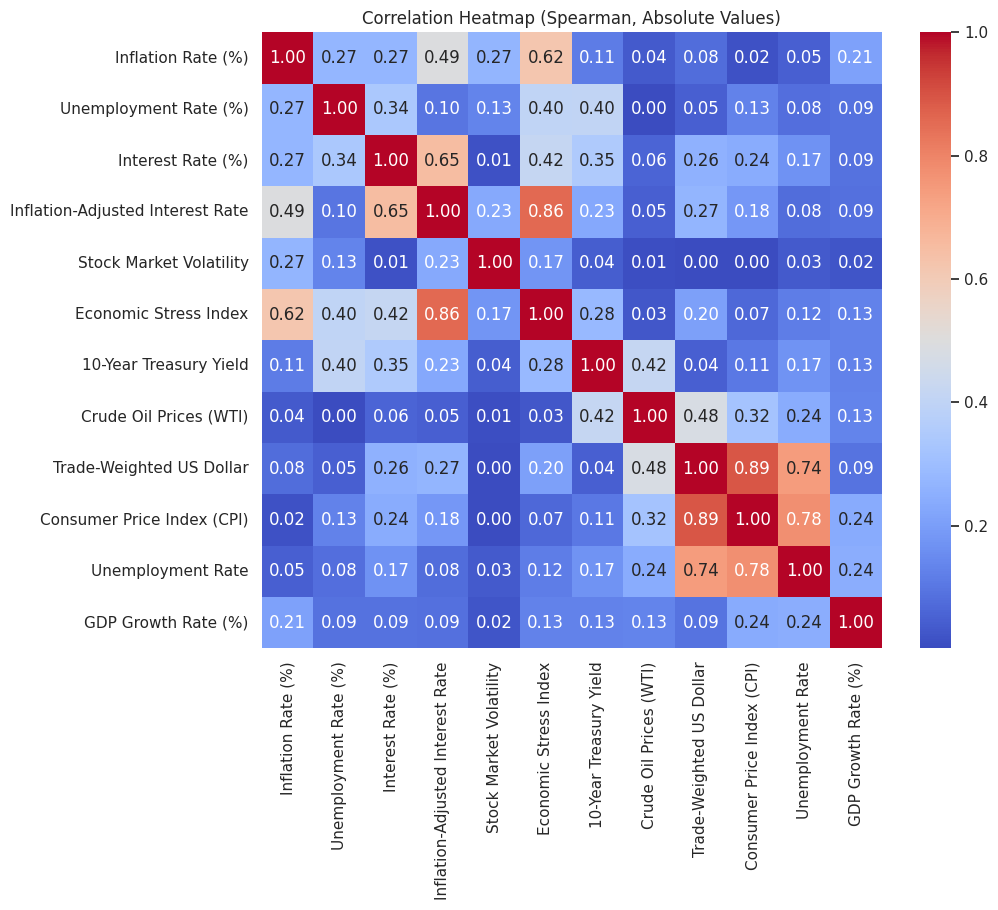

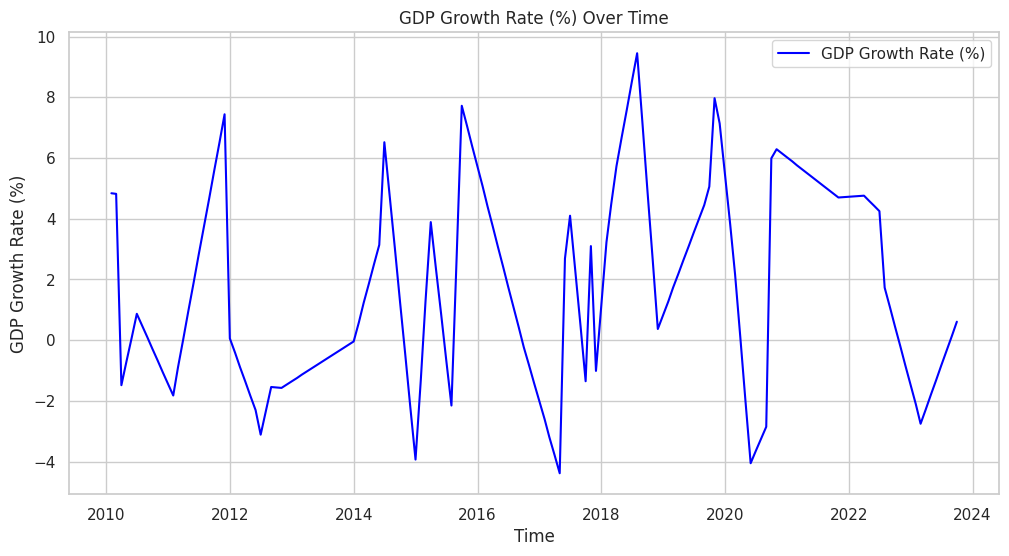

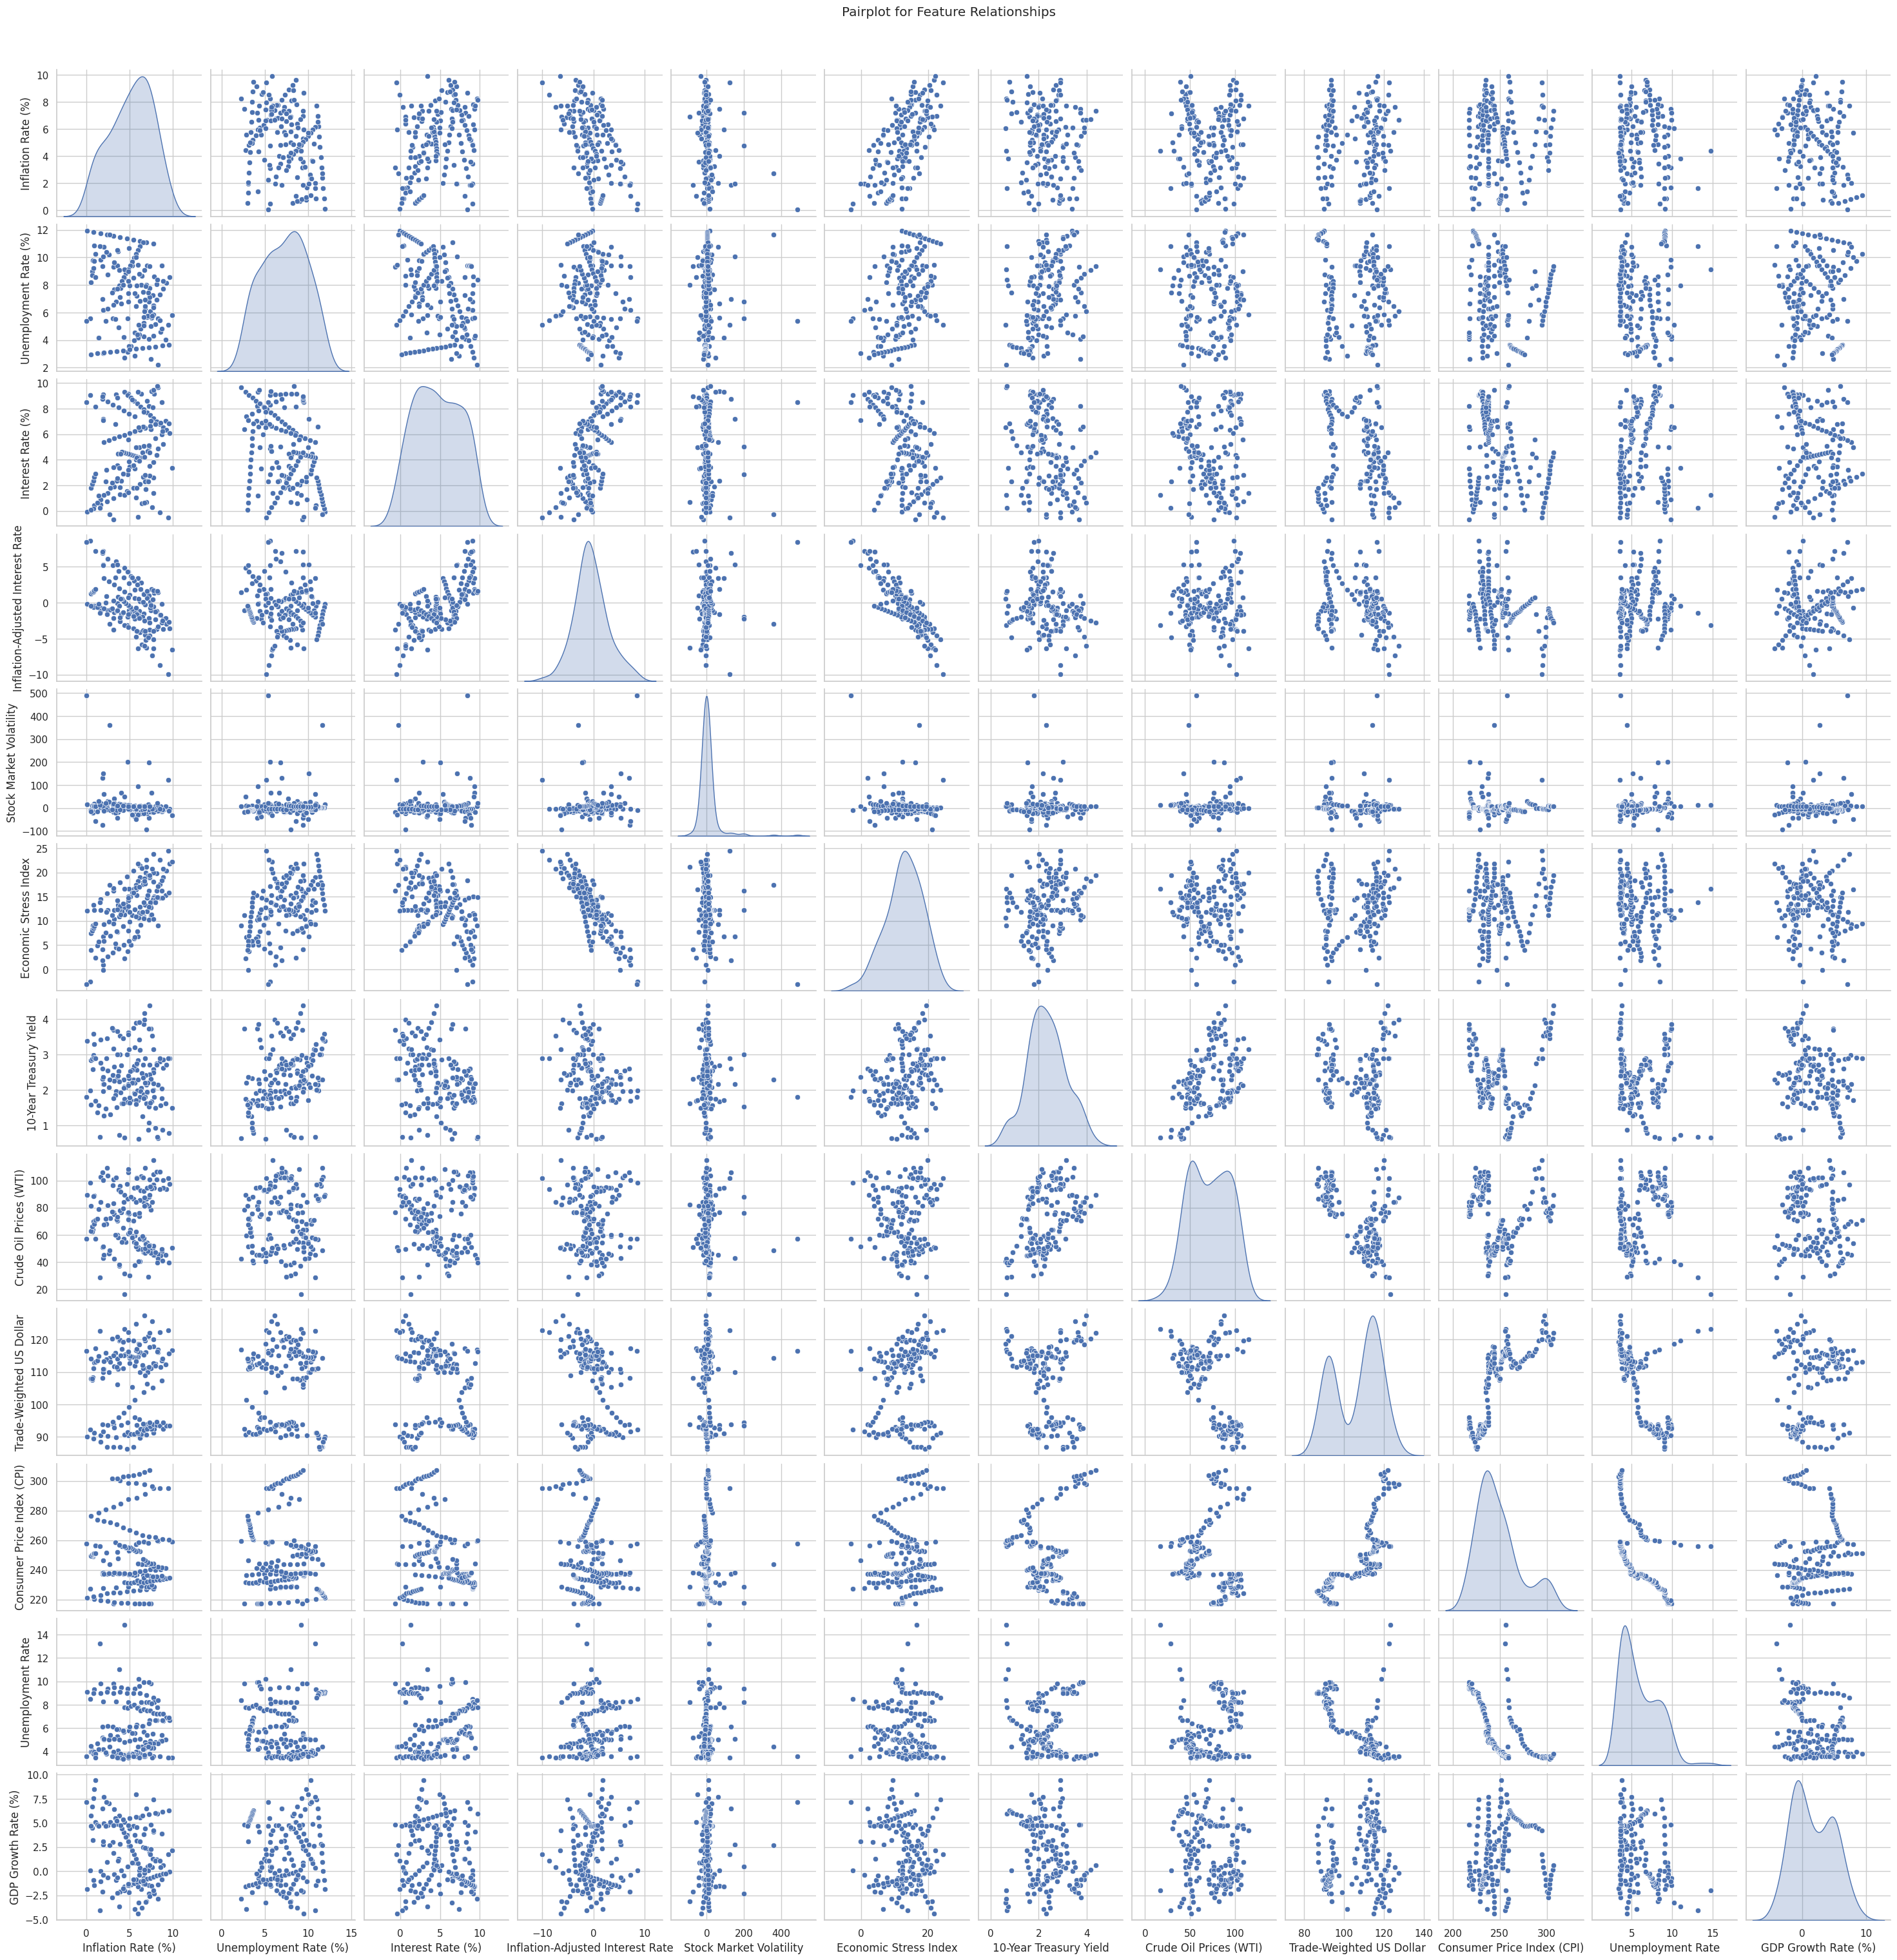

In [8]:
# Ensure time-series correlation calculation using Spearman and absolute values
correlation = usa_data.drop(columns=['Country']).corr(method='spearman').abs()  # Spearman correlation and absolute values

# Sort correlations with GDP Growth Rate (%)
gdp_correlation = correlation['GDP Growth Rate (%)'].sort_values(ascending=False)
print("\nCorrelation with GDP Growth Rate (%):")
print(gdp_correlation)

# Plot heatmap for correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap (Spearman, Absolute Values)")
plt.show()

# Line plot for GDP Growth Rate over time
plt.figure(figsize=(12, 6))
plt.plot(usa_data.index, usa_data['GDP Growth Rate (%)'], label='GDP Growth Rate (%)', color='blue')
plt.title("GDP Growth Rate (%) Over Time")
plt.xlabel("Time")
plt.ylabel("GDP Growth Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

# Pairplot for feature relationships
selected_features = ['Inflation Rate (%)', 'Unemployment Rate (%)', 'Interest Rate (%)',
                     'Inflation-Adjusted Interest Rate', 'Stock Market Volatility', 'Economic Stress Index',
                     '10-Year Treasury Yield', 'Crude Oil Prices (WTI)', 'Trade-Weighted US Dollar', 'Consumer Price Index (CPI)',
                     'Unemployment Rate']
sns.pairplot(usa_data, vars=selected_features + ['GDP Growth Rate (%)'], diag_kind='kde', height=2.5)
plt.suptitle("Pairplot for Feature Relationships", y=1.02)
plt.show()


### **2.2 Preparing The 'usa_data' For Model Run**
### **Shifting Prediction**
### **Splitting to Train-set, Test-set, Future_row for Prediction**

In [9]:
# Shift Bitcoin_Price column upwards by one row to predict next day's price
usa_data['GDP Growth Rate (%)'] = usa_data['GDP Growth Rate (%)'].shift(-1)

# Drop the Date column as it is not a feature
usa_data = usa_data.drop(columns=['Date', 'Country'], errors='ignore')

# Separate the last row for future prediction
future_row = usa_data.iloc[[-1]]
usa_data = usa_data.iloc[:-1]

# Split the data into features (X) and prediction target (y)
X = usa_data.drop(columns=['GDP Growth Rate (%)'])  # Features
y = usa_data['GDP Growth Rate (%)']                # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets for verification
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

# Display the future row for prediction verification
print("\nFuture row for prediction:")
future_row

Training set shape (X_train, y_train): (131, 11) (131,)
Testing set shape (X_test, y_test): (33, 11) (33,)

Future row for prediction:


,Inflation Rate (%),Unemployment Rate (%),Interest Rate (%),Inflation-Adjusted Interest Rate,Stock Market Volatility,Economic Stress Index,10-Year Treasury Yield,Crude Oil Prices (WTI),Trade-Weighted US Dollar,Consumer Price Index (CPI),Unemployment Rate,GDP Growth Rate (%)
Date,,,,,,,,,,,,
2023-09-30,7.32,9.36,4.58,-2.74,6.214361,19.42,4.38,89.425,121.982685,307.288,3.8,NaN


## **3. Model Design and Training**

### **3.1 Random Forest Model**

In [10]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configure and run the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Configure the model

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='r2', verbose=2, n_jobs=-1)

y_train = y_train.values

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best R^2 Score:", grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best R^2 Score: 0.30880840887418554


In [11]:
# Retrieve the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the model on the testing set
y_pred = best_rf_model.predict(X_test)
print("\nModel Evaluation:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Predict the Bitcoin price for the future row
future_prediction = best_rf_model.predict(future_row.drop(columns=['GDP Growth Rate (%)'], errors='ignore'))
print("\nPredicted GDP Growth Rate (%) for the future row:", future_prediction)


Model Evaluation:
Mean Squared Error: 2.093202056329346
R^2 Score: 0.7984153011139511

Predicted GDP Growth Rate (%) for the future row: [0.35110688]


### **3.2 GRU Model**

Epoch 10/50, Loss: 13.5259
Epoch 20/50, Loss: 12.3741
Epoch 30/50, Loss: 11.6709
Epoch 40/50, Loss: 11.1404
Epoch 50/50, Loss: 10.8681
GRU Model MAPE: 134.71%


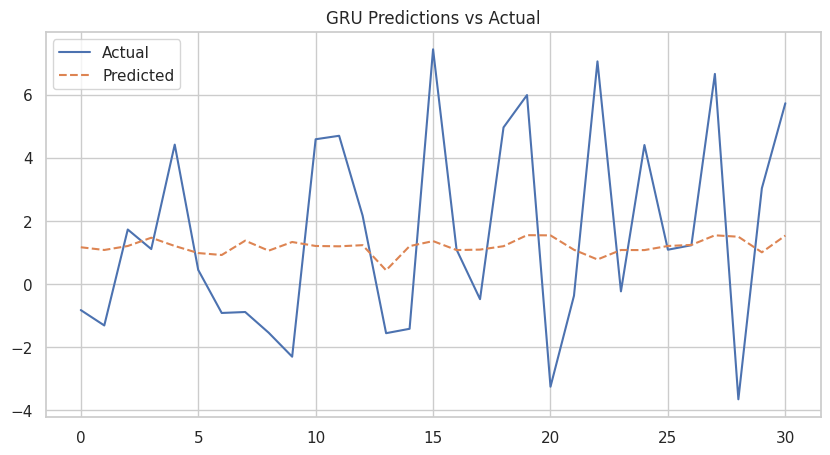

In [12]:
# Define the GRU model for predicting GDP Growth Rate (%)
class GRURegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# Prepare the data for GRU model
window_size = 12
features = [col for col in usa_data.columns if col != 'GDP Growth Rate (%)']

# Convert to numpy arrays
X = usa_data[features].values.astype(float)
y = usa_data['GDP Growth Rate (%)'].values.astype(float)

# Create sequences
def create_sequences(data_x, data_y, window=12):
    sequence_x, sequence_y = [], []
    for i in range(len(data_x) - window):
        sequence_x.append(data_x[i:i+window])
        sequence_y.append(data_y[i+window])
    return np.array(sequence_x, dtype=np.float32), np.array(sequence_y, dtype=np.float32)

X_seq, y_seq = create_sequences(X, y, window=window_size)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# Instantiate the GRU model
input_size = X_train.shape[2]
gru_model = GRURegressor(input_size=input_size, hidden_size=32).to(device)
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the GRU model
epochs = 50
gru_model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = gru_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the GRU model
gru_model.eval()
gru_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = gru_model(sequence)
        gru_predictions.append(pred.item())

# Calculate evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

mape = mean_absolute_percentage_error(y_test, gru_predictions)
print(f"GRU Model MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(gru_predictions)), gru_predictions, label="Predicted", linestyle='--')
plt.title("GRU Predictions vs Actual")
plt.legend()
plt.show()


### **3.3 LSTM Model**

Epoch 10/50, Loss: 13.0533
Epoch 20/50, Loss: 12.2488
Epoch 30/50, Loss: 11.8005
Epoch 40/50, Loss: 11.3207
Epoch 50/50, Loss: 10.8801
LSTM Model MAPE: 126.49%


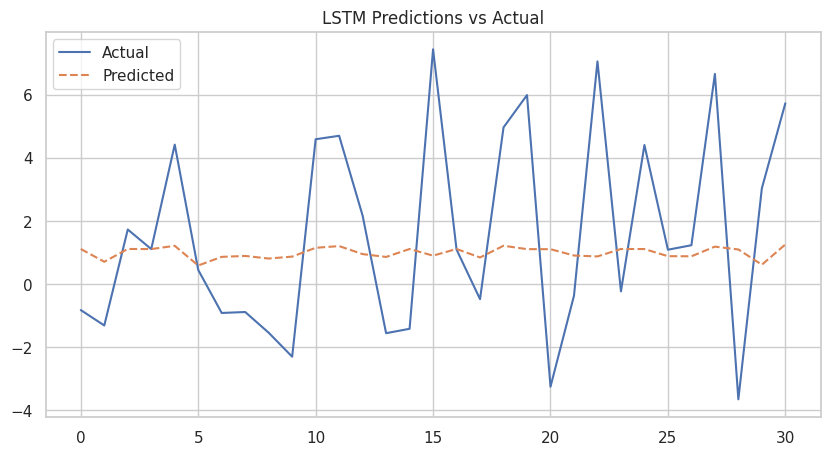

In [13]:
# Define the LSTM model for predicting GDP Growth Rate (%)
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

# Instantiate the LSTM model
input_size = X_train.shape[2]
lstm_model = LSTMRegressor(input_size=input_size, hidden_size=32).to(device)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion_lstm = nn.MSELoss()

# Train the LSTM model
epochs = 50
lstm_model.train()
for epoch in range(epochs):
    optimizer_lstm.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion_lstm(predictions, y_train_t)
    loss.backward()
    optimizer_lstm.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = lstm_model(sequence)
        lstm_predictions.append(pred.item())

# Calculate evaluation metrics for LSTM
lstm_mape = mean_absolute_percentage_error(y_test, lstm_predictions)
print(f"LSTM Model MAPE: {lstm_mape:.2f}%")

# Plot results for LSTM
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(lstm_predictions)), lstm_predictions, label="Predicted", linestyle='--')
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()


Epoch 10/50, Loss: 10.6385
Epoch 20/50, Loss: 10.4830
Epoch 30/50, Loss: 9.8528
Epoch 40/50, Loss: 8.9951
Epoch 50/50, Loss: 8.3503
Transformer Model MAPE: 174.67%


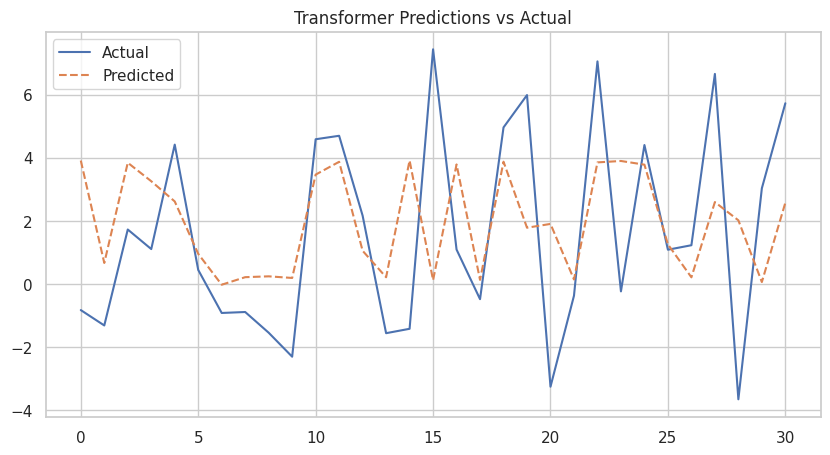

In [14]:
# Define a Transformer-based model for predicting GDP Growth Rate (%)
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, num_heads=4, hidden_size=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.input_proj(x)  # Project input to the transformer dimension
        x = self.transformer(x)  # Pass through the transformer encoder
        x = self.fc(x[:, -1, :])  # Take the output of the last time step for prediction
        return x.squeeze(-1)

# Instantiate the Transformer model
input_size = X_train.shape[2]
transformer_model = TransformerRegressor(
    input_size=input_size, num_heads=4, hidden_size=64, num_layers=2, dropout=0.1
).to(device)
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.001)
criterion_transformer = nn.MSELoss()

# Train the Transformer model
epochs = 50
transformer_model.train()
for epoch in range(epochs):
    optimizer_transformer.zero_grad()
    predictions = transformer_model(X_train_t)
    loss = criterion_transformer(predictions, y_train_t)
    loss.backward()
    optimizer_transformer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the Transformer model
transformer_model.eval()
transformer_predictions = []
with torch.no_grad():
    for i in range(X_test_t.shape[0]):
        sequence = X_test_t[i].unsqueeze(0)
        pred = transformer_model(sequence)
        transformer_predictions.append(pred.item())

# Calculate evaluation metrics for the Transformer model
transformer_mape = mean_absolute_percentage_error(y_test, transformer_predictions)
print(f"Transformer Model MAPE: {transformer_mape:.2f}%")

# Plot results for the Transformer model
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label="Actual")
plt.plot(range(len(transformer_predictions)), transformer_predictions, label="Predicted", linestyle='--')
plt.title("Transformer Predictions vs Actual")
plt.legend()
plt.show()
